<a href="https://colab.research.google.com/github/devikaranidivvela/Bharath-Intern/blob/main/Mining_Twitter_Data_for_Sentiment_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! pip install WordCloud

In [ ]:
from google.colab import files
files.upload()


TypeError: 'NoneType' object is not subscriptable

In [3]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.49GB/s]


In [5]:
#extracting a compressed dataset from zip file
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset,'r') as zip:#r-read
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing the Dependencies

In [6]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Data Preprocessing

In [9]:
tweet_data=pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding='latin')

In [10]:
tweet_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
tweet_data.shape

(1599999, 6)

In [12]:
 #naming the columns and reading the dataset again

 column_names=['target','ids','date','flag','user','text']
 tweet_data=pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding='latin',names=column_names)

In [13]:
tweet_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
tweet_data.shape

(1600000, 6)

In [15]:
#checking missing values
tweet_data.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


converting 4 to 1 in target variable

In [16]:
tweet_data.replace({4:1},inplace=True)

In [17]:
tweet_data['target'].value_counts()

,count
target,
0,800000
1,800000


0--->negative tweet
1-->positive tweet

Text(0.5, 1.0, 'Distribution of sentiments')

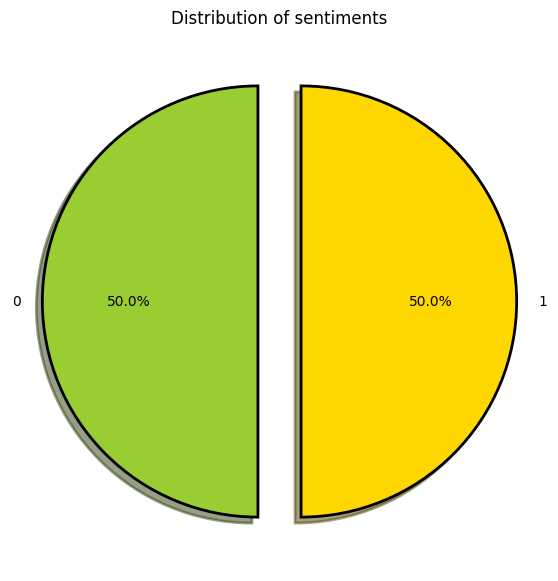

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_data['target'].value_counts()
explode = (0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

**Stemming**

reducing a word to its root word

In [19]:
ps=PorterStemmer()

In [20]:
def stemming(content):
  stemmed_content=re.sub('[^a-zA-Z]',' ',content)
  stemmed_content=stemmed_content.lower()
  stemmed_content=stemmed_content.split()
  stemmed_content=[ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content=' '.join(stemmed_content)
  return stemmed_content

Applying this stemming function to the text data in the dataset through apply method

In [ ]:
tweet_data['stemmed_content']=tweet_data['text'].apply(stemming)

In [ ]:
tweet_data.head()

,target,ids,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
all_stemmed_words = ' '.join(tweet_data['stemmed_content'].astype(str).unique())


Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

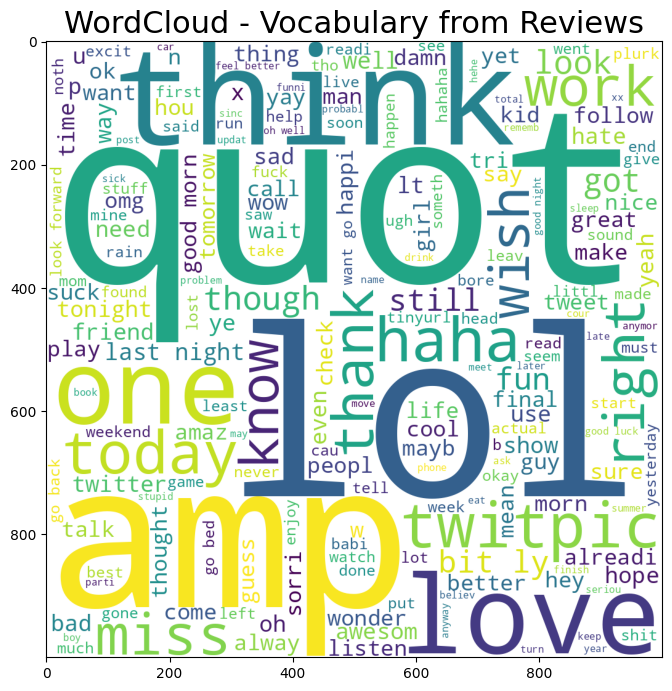

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate(all_stemmed_words)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

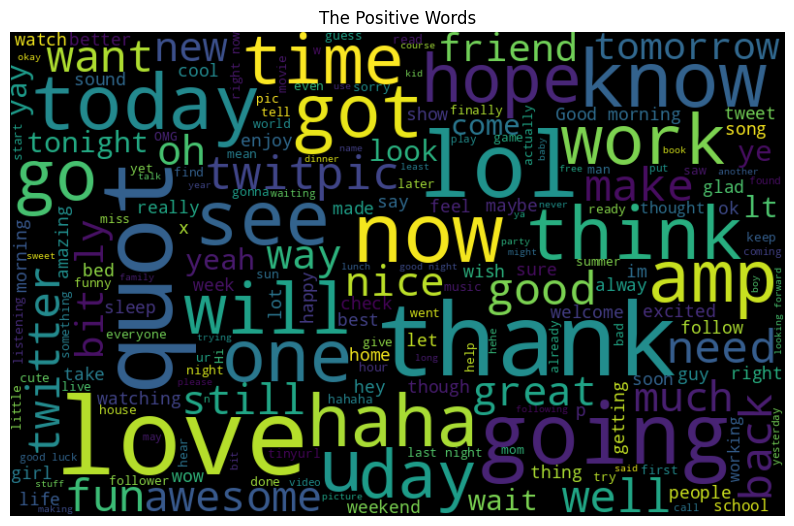

In [ ]:
normal_words =' '.join([text for text in tweet_data['text'][tweet_data['target'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

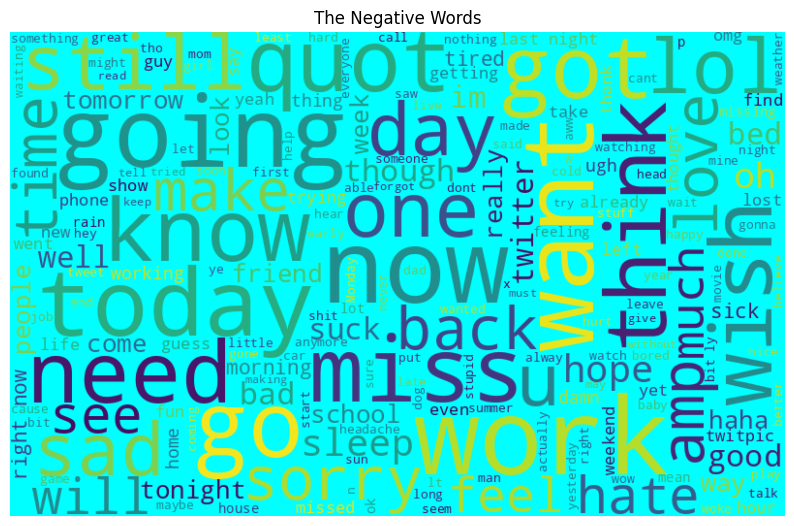

In [ ]:
normal_words =' '.join([text for text in tweet_data['text'][tweet_data['target'] == 0]])

wordcloud = WordCloud(background_color='cyan',width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [ ]:
print(tweet_data[['stemmed_content','text']])

                                           stemmed_content  \
0        switchfoot http twitpic com zl awww bummer sho...   
1        upset updat facebook text might cri result sch...   
2        kenichan dive mani time ball manag save rest g...   
3                          whole bodi feel itchi like fire   
4                            nationwideclass behav mad see   
...                                                    ...   
1599995                         woke school best feel ever   
1599996  thewdb com cool hear old walt interview http b...   
1599997                       readi mojo makeov ask detail   
1599998  happi th birthday boo alll time tupac amaru sh...   
1599999  happi charitytuesday thenspcc sparkschar speak...   

                                                      text  
0        @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1        is upset that he can't update his Facebook by ...  
2        @Kenichan I dived many times for the ball. Man...  
3          

In [ ]:
print(tweet_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
#separting the data and label
X=tweet_data['stemmed_content'].values
y=tweet_data['target'].values

In [ ]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(y)

[0 0 0 ... 1 1 1]


Splitting the data into Train and Test

Stratify means to maintain the equal proporation of data

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=2)

In [ ]:
print(X.shape,X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
#converting textual data to numerical data
tv=TfidfVectorizer()
X_train=tv.fit_transform(X_train)
X_test=tv.transform(X_test)

In [ ]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [ ]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


Training the Machine Learning Model

***Logistic Regression***

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.79871953125
Validation Accuracy : 0.77668125
F1 score : 0.7808223379523135
[[121246  38754]
 [ 32708 127292]]


Model Accuracy=77.6%

In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.74437421875
Validation Accuracy : 0.739390625
F1 score : 0.7595861404919843
[[104862  55138]
 [ 28257 131743]]


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
! pip install xgboost

**Saving Trained model**

In [ ]:
import pickle

In [ ]:
filename='trained_model.sav'
pickle.dump(model,open(filename,'wb'))#write a file-wb(b-binary)

Using the saved model for future predictions

In [ ]:
#loading the model
loaded_model=pickle.load(open('/content/trained_model.sav','rb'))

In [ ]:
X_new=X_test[20]
print(y_test[20])
pred=model.predict(X_new)
print(pred)
if pred[0]==0:
  print("Negative Tweet")
else:
  print("Positive Tweet")


1
[1]
Positive Tweet


In [ ]:
X_new=X_test[2]
print(y_test[2])
pred=model.predict(X_new)
print(pred)
if pred[0]==0:
  print("Negative Tweet")
else:
  print("Positive Tweet")


0
[0]
Negative Tweet
